In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

%matplotlib inline
%load_ext autoreload

In [2]:
from hiveplot import HivePlot
%autoreload 2

In [3]:
def golden_figsize(height):
    """
    Assuming height dimension is the shorter one, the width should be:
    (1 + 5**0.5)/2
    
    This function thus returns the (width, height) tuple which is
    computed to be in a golden ratio.
    """
    width = height * (1 + 5**0.5) / 2
    return (width, height)

In [4]:
G = nx.read_gpickle('20141103 All IRD Final Graph.pkl')

In [7]:
# Add in ecotype information

# Load the data
df = pd.read_csv('Country-Species_coded.csv', index_col=0)
df['Habitat/setting'] = df['Habitat/setting'].replace('Domestic ', 'Domestic')
# Make it into a dicitonary where each entry is (country, species):habitat/setting
ecotype_map = dict()

for row, data in df.iterrows():
    country = data['Country']
    species = data['Species']
    ecotype = data['Habitat/setting']

    ecotype_map[(country, species)] = ecotype

# Add the ecotype into each node.
for n, d in G.nodes(data=True):
    country = d['country']
    species = d['host_species']
    if '/' in species:
        species = species.split('/')[0]
    if 'null' in species:
        species = 'Unknown'


    
    G.node[n]['ecotype'] = ecotype_map[(country, species)]

In [8]:
((u, v, d) for u, v, d in G.edges(data=True) if d['edge_type'] != 'full_complement').next()

def is_reassortant_edge(G, sc, sk):
    d = G.edge[sc][sk]
    if d['edge_type'] == 'reassortant':
        return True
    else:
        return False

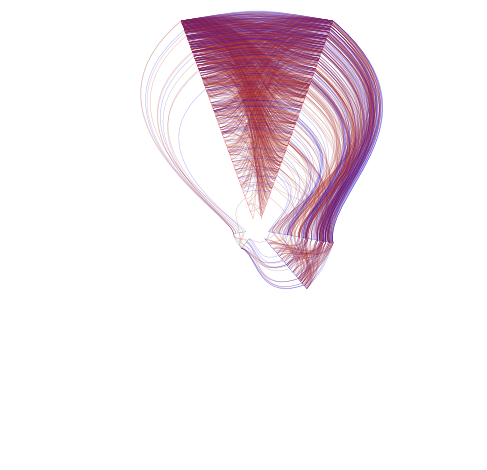

In [9]:
# Prototype code for drawing hive plots using the hiveplot package.
subtypeG = nx.DiGraph()
for sc, sk, d in G.edges(data=True):
    if d['edge_type'] == 'reassortant':
        sc_ecotype = G.node[sc]['ecotype']
        sc_subtype = G.node[sc]['subtype'] + '_{0}'.format(sc_ecotype)
        sc_host = G.node[sc]['host_species']

        sk_ecotype = G.node[sk]['ecotype']
        sk_subtype = G.node[sk]['subtype'] + '_{0}'.format(sk_ecotype)
        sk_host = G.node[sk]['host_species']

        if sc_subtype not in subtypeG.nodes():
            subtypeG.add_node(sc_subtype, ecotype=sc_ecotype, subtype=G.node[sc]['subtype'], host_species=sc_host)
        if sk_subtype not in subtypeG.nodes():
            subtypeG.add_node(sk_subtype, ecotype=sk_ecotype, subtype=G.node[sk]['subtype'], host_species=sk_host)

        subtypeG.add_edge(sc_subtype, sk_subtype, direction='{0}_{1}'.format(sc_ecotype, sk_ecotype))
    
# Modify the nodes a bit
for n, d in subtypeG.nodes(data=True):
    if d['host_species'] == 'Human':
        subtypeG.node[n]['ecotype'] = 'Human'
    if d['ecotype'] == 'Unknown':
        subtypeG.node[n]['ecotype'] = "Wild"
# Update edges based on modified nodes
for sc, sk, d in subtypeG.edges(data=True):
    subtypeG.edge[sc][sk]['direction'] = '{0}_{1}'.format(subtypeG.node[sc]['ecotype'], subtypeG.node[sk]['ecotype'])

# Load in the subtype centralities as calculated from the whole graph.
subtype_centralities = pd.read_csv('Subtype Reassortment Centralities.csv', index_col=0)
subtype_centralities.set_index('Subtype', inplace=True)
ecotypes = ['Wild', 'Human', 'Domestic']

# Sort the wild and domestic subtypes by "hub"-ness. 
nodes = dict()
for ecotype in ecotypes:
    nodes[ecotype] = []

for n, d in subtypeG.nodes(data=True):
    subtype = n.split('_')[0]
    centrality = subtype_centralities.ix[subtype]['Degree Centrality']
    ecotype = n.split('_')[1]
    if ecotype == 'Unknown':
        ecotype = 'Wild'
    if d['host_species'] == 'Human':
        ecotype = 'Human'
    nodes[ecotype].append((n, centrality))

for group, nodelist in nodes.items():
    nodes[group] = [i[0] for i in sorted(nodelist, key=lambda x:x[1])]


edges = dict()
edges['Same Subtype'] = []
edges['Different Subtype'] = []
for u, v, d in subtypeG.edges(data=True):
    if subtypeG.node[u]['subtype'] == subtypeG.node[v]['subtype']:
        edges['Same Subtype'].append((u,v,d))
    else:
        edges['Different Subtype'].append((u,v,d))
        
    
cmap = dict()
cmap['Domestic'] = 'blue'
cmap['Wild'] = 'red'
cmap['Human'] = 'green'

edge_cmap = dict()
edge_cmap['Same Subtype'] = 'blue'
edge_cmap['Different Subtype'] = 'brown'

from hiveplot import HivePlot
%autoreload 2

h = HivePlot(nodes, edges, cmap, edge_cmap)
h.draw()



In [10]:
def correct_metadata(G, node):
    """
    Helper function for providing the correct subtype graph metadata.    
    """
    d = G.node[node]
    subtype = d['subtype']
    ecotype = d['ecotype']
    host = d['host_species']
    if ecotype == 'Unknown':
        ecotype = 'Wild'
    if host == 'Human':
        ecotype = 'Human'
    subtype = subtype + '_' + ecotype
    
    return ecotype, subtype, host
    

In [11]:
def is_reassortant(G, node):
    d = G.node[node]
    return d['reassortant']

# def is_reassortant_edge(G, node)

In [12]:
# Helper functions to reduce code length.
def plot_subtypeG_hiveplot(subtypeG, groups, subhandle):
    # Load in the subtype centralities as calculated from the whole graph.
    subtype_centralities = pd.read_csv('Subtype Reassortment Centralities.csv', index_col=0)
    subtype_centralities.set_index('Subtype', inplace=True)

    ### Sort the wild and domestic subtypes by "hub"-ness. 
    # Prepare the nodes dictionary by ecotype group
    nodes = dict()
    for ecotype in groups:
        nodes[ecotype] = []

    # Add in the nodes along with their centralities.
    for n, d in subtypeG.nodes(data=True):
        subtype = subtypeG.node[n]['subtype']
        centrality = subtype_centralities.loc[subtype]['Degree Centrality']
        ecotype = d['ecotype']
        nodes[ecotype].append((n, centrality))

    # Sort the edges
    for group, nodelist in nodes.items():
        nodes[group] = [i[0] for i in sorted(nodelist, key=lambda x:x[1], reverse=True)]

    # Group the edges together
    edges = dict()
    edges['Same Subtype'] = []
    edges['Different Subtype'] = []
    for u, v, d in subtypeG.edges(data=True):
        if subtypeG.node[u]['subtype'] == subtypeG.node[v]['subtype']:
            edges['Same Subtype'].append((u,v,d))
        else:
            edges['Different Subtype'].append((u,v,d))

    # Make the node color mapping
    cmap = dict(zip(groups, ['black', 'black', 'black']))
    
    edge_groups = ['Same Subtype', 'Different Subtype']
    edges = dict(zip(edge_groups, ([], [])))
#     edges['Same Subtype'] = []
#     edges['Different Subtype'] = []
    for u, v, d in subtypeG.edges(data=True):
        if subtypeG.node[u]['subtype'] == subtypeG.node[v]['subtype']:
            edges['Same Subtype'].append((u,v,d))
        else:
            edges['Different Subtype'].append((u,v,d))

    edge_cmap = dict(zip(edge_groups, ['green', 'blue']))

    fig = plt.figure(figsize=(1.5,1.5))
    ax = fig.add_subplot(111)
    h = HivePlot(nodes, edges, cmap, edge_colormap=edge_cmap, fig=fig, ax=ax, linewidth=0.2)
    h.draw()
    
def save_hiveplot(ax, title_handle, subhandle, subfig_letter):
    ax.set_title(title_handle)
    plt.subplots_adjust(top=0.78, bottom=0.05, left=0.05, right=0.95)
    ax.set_aspect('equal')
    ax.annotate(subfig_letter, ha='left', va='top', xy=(0,1), xycoords='figure fraction')
    plt.savefig('Hive Plot - {0}.pdf'.format(subhandle))
    
def add_all_nodes(subtypeG, G, groups):
    for n, d in G.nodes(data=True):
        subtype = d['subtype']

        for ecotype in groups:
            sub_eco = subtype + '_' + ecotype
            if sub_eco not in subtypeG.nodes():
                subtypeG.add_node(sub_eco, ecotype=ecotype, subtype=subtype)

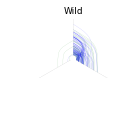

In [13]:
%autoreload 2
from hiveplot import HivePlot
# Here, we only plot those going into wild.
subtypeG = nx.DiGraph()
groups = ['Wild', 'Domestic', 'Human']
assert len(groups) <= 3 and len(groups) > 0, 'Length of groups must be between 1 and 3 inclusive.'

# Add in the subtype nodes to each axis.
# This step here ensures that every subtype is represented on each axis
add_all_nodes(subtypeG, G, groups)
       
# This adds the subtypic edges that we want into the subtype graph.
# Rewrite this section to filter out only the edges of interest.
for sc, sk, d in G.edges(data=True):
    sc_ecotype, sc_subtype, sc_host = correct_metadata(G, sc)
    sk_ecotype, sk_subtype, sk_host = correct_metadata(G, sk)
    
    if sk_ecotype == 'Wild' and sk_ecotype != sc_ecotype:
        subtypeG.add_edge(sc_subtype, sk_subtype, direction='{0}_{1}'.format(sc_ecotype, sk_ecotype))
    
plot_subtypeG_hiveplot(subtypeG, groups, 'Interactions Into Wild Subtypes')
save_hiveplot(plt.gca(), 'Wild', 'Interactions into Wild Subtypes',  '')

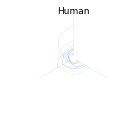

In [14]:
# Here, we only plot those going into human.
subtypeG = nx.DiGraph()
groups = ['Wild', 'Domestic', 'Human']
assert len(groups) <= 3 and len(groups) > 0, 'Length of groups must be between 1 and 3 inclusive.'

# Add in the subtype nodes to each axis.
# This step here ensures that every subtype is represented on each axis
add_all_nodes(subtypeG, G, groups)
       
# This adds the subtypic edges that we want into the subtype graph.
# Rewrite this section to filter out only the edges of interest.
for sc, sk, d in G.edges(data=True):
    sc_ecotype, sc_subtype, sc_host = correct_metadata(G, sc)
    sk_ecotype, sk_subtype, sk_host = correct_metadata(G, sk)
    
    if sk_ecotype == 'Human' and sk_ecotype != sc_ecotype:
        subtypeG.add_edge(sc_subtype, sk_subtype, direction='{0}_{1}'.format(sc_ecotype, sk_ecotype))
    
plot_subtypeG_hiveplot(subtypeG, groups, 'Interactions into Human Subtypes')
save_hiveplot(plt.gca(), 'Human', 'Interactions into Human Subtypes', '')

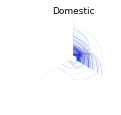

In [15]:
# Here, we only plot those going into human.
subtypeG = nx.DiGraph()
groups = ['Wild', 'Domestic', 'Human']
assert len(groups) <= 3 and len(groups) > 0, 'Length of groups must be between 1 and 3 inclusive.'

# Add in the subtype nodes to each axis.
# This step here ensures that every subtype is represented on each axis
add_all_nodes(subtypeG, G, groups)
       
# This adds the subtypic edges that we want into the subtype graph.
# Rewrite this section to filter out only the edges of interest.
for sc, sk, d in G.edges(data=True):
    sc_ecotype, sc_subtype, sc_host = correct_metadata(G, sc)
    sk_ecotype, sk_subtype, sk_host = correct_metadata(G, sk)
    
    if sk_ecotype == 'Domestic' and sk_ecotype != sc_ecotype:
        subtypeG.add_edge(sc_subtype, sk_subtype, direction='{0}_{1}'.format(sc_ecotype, sk_ecotype))
    
plot_subtypeG_hiveplot(subtypeG, groups, 'Interactions into Domestic Animal Subtypes')
save_hiveplot(plt.gca(), 'Domestic', 'Interactions into Domestic Animal Subtypes', '')

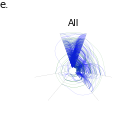

In [16]:
# Let's try making sure that every subtype is represented on every axis, so that there is no ambiguity about the 
# ranked order of influenza subtypes' interconnectivity

subtypeG = nx.DiGraph()
groups = ['Wild', 'Domestic', 'Human']
assert len(groups) <= 3 and len(groups) > 0, 'Length of groups must be between 1 and 3 inclusive.'

# Add in the subtype nodes to each axis.
# This step here ensures that every subtype is represented on each axis
add_all_nodes(subtypeG, G, groups)

# This adds the subtypic edges that we want into the subtype graph.
# Rewrite this section to filter out only the edges of interest.
for sc, sk, d in G.edges(data=True):
    sc_ecotype, sc_subtype, sc_host = correct_metadata(G, sc)
    sk_ecotype, sk_subtype, sk_host = correct_metadata(G, sk)
    
    subtypeG.add_edge(sc_subtype, sk_subtype, direction='{0}_{1}'.format(sc_ecotype, sk_ecotype))
    
plot_subtypeG_hiveplot(subtypeG, groups, 'All Inter-Subtype Interactions')
save_hiveplot(plt.gca(), 'All', 'All Inter-Subtype Interactions', 'e.')

In [17]:
# Continuing on the above cell, let's compare the distribution of centralities changes for each interface.
# Firstly, let's just do human-to-human interface, as it's very sparse.
centralities = pd.read_csv('Subtype Reassortment Centralities.csv', index_col=0)
centralities.set_index('Subtype', inplace=True)

# Store the counts of number of cross-subtype vs. same-subtype interactions at each directional interface.
cts = dict()

for sc, sk, d in subtypeG.edges(data=True):
    sc_subtype = subtypeG.node[sc]['subtype']
    sk_subtype = subtypeG.node[sk]['subtype']

    sc_ecotype = subtypeG.node[sc]['ecotype']
    sk_ecotype = subtypeG.node[sk]['ecotype']
    
    direction = sc_ecotype + '_' + sk_ecotype
    
    if direction not in cts.keys():
        cts[direction] = Counter()
        
    if sc_subtype == sk_subtype:
        cts[direction]['same_subtype'] += 1
    
    if sc_subtype != sk_subtype:
        cts[direction]['diff_subtype'] += 1

def normalize_counter(counter):
    total = sum(counter.values())
    
    props = dict()
    
    for k, v in counter.items():
        props[k] = float(v) / float(total)
        
    return props

props = dict()
for k, counter in cts.items():
    props[k] = normalize_counter(counter)
    
props

{'Domestic_Domestic': {'diff_subtype': 0.8241758241758241,
  'same_subtype': 0.17582417582417584},
 'Domestic_Human': {'diff_subtype': 0.3333333333333333,
  'same_subtype': 0.6666666666666666},
 'Domestic_Wild': {'diff_subtype': 0.7913669064748201,
  'same_subtype': 0.20863309352517986},
 'Human_Domestic': {'diff_subtype': 0.5384615384615384,
  'same_subtype': 0.46153846153846156},
 'Human_Human': {'diff_subtype': 0.5714285714285714,
  'same_subtype': 0.42857142857142855},
 'Human_Wild': {'diff_subtype': 0.25, 'same_subtype': 0.75},
 'Wild_Domestic': {'diff_subtype': 0.8367346938775511,
  'same_subtype': 0.16326530612244897},
 'Wild_Human': {'diff_subtype': 0.6, 'same_subtype': 0.4},
 'Wild_Wild': {'diff_subtype': 0.9207729468599034,
  'same_subtype': 0.07922705314009662}}

In [18]:
def get_abbr_ecotype_label(ecotype):
    if ecotype == 'Wild':
        return 'W'
    if ecotype == 'Domestic':
        return "D"
    if ecotype == 'Human':
        return 'H'

(0, 'Domestic_Domestic', Counter({'diff_subtype': 150, 'same_subtype': 32}))
(4, 'Domestic_Human', Counter({'same_subtype': 8, 'diff_subtype': 4}))
(1, 'Domestic_Wild', Counter({'diff_subtype': 110, 'same_subtype': 29}))
(3, 'Human_Domestic', Counter({'diff_subtype': 7, 'same_subtype': 6}))
(8, 'Human_Human', Counter({'diff_subtype': 8, 'same_subtype': 6}))
(7, 'Human_Wild', Counter({'same_subtype': 3, 'diff_subtype': 1}))
(5, 'Wild_Domestic', Counter({'diff_subtype': 164, 'same_subtype': 32}))
(6, 'Wild_Human', Counter({'diff_subtype': 9, 'same_subtype': 6}))
(2, 'Wild_Wild', Counter({'diff_subtype': 953, 'same_subtype': 82}))


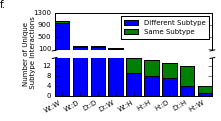

In [19]:
fig = plt.figure(figsize=(3, 1.5))
ax1 = fig.add_subplot(111)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(212)

# Initialize the data to be added.
data = list()

for i, (interaction, prop) in sorted(enumerate(cts.items()), key=lambda x:x[1][0]):
    print(i, interaction, prop)
    start = get_abbr_ecotype_label(interaction.split('_')[0])
    end = get_abbr_ecotype_label(interaction.split('_')[1])
    
    label = start + '::' + end ### first thing to add into the tuple
    diffprop = prop['diff_subtype']
    sameprop = prop['same_subtype']
    
    data.append((label, diffprop, sameprop))
    
# Sort the data
data = sorted(data, key=lambda x:x[1], reverse=True)
# Plot the data
labels = []
i_vals = []
diffprop_vals = []
sameprop_vals = []

for i, (label, diffprop, sameprop) in enumerate(data):
    labels.append(label)
    i_vals.append(i)
    diffprop_vals.append(diffprop)
    sameprop_vals.append(sameprop)

ax2.bar(i_vals, diffprop_vals, label='Different Subtype', color='blue', align='center')
ax2.bar(i_vals, sameprop_vals, bottom=diffprop_vals, label='Same Subtype', color='green', align='center')
ax2.legend()
ax2.set_ylim(50, 1000)

ax3.bar(i_vals, diffprop_vals, label='Different Subtype', color='blue', align='center')
ax3.bar(i_vals, sameprop_vals, bottom=diffprop_vals, label='Same Subtype', color='green', align='center')
ax3.set_ylim(0, 15)

ax1.get_yaxis().set_ticks([])
ax1.get_xaxis().set_ticks([])
ax2.get_xaxis().set_ticks([])
ax3.get_xaxis().set_ticks([])
ax3.get_xaxis().set_ticks_position('bottom')

# Eliminate the spines that we don't need.
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax3.spines['top'].set_visible(False)
    
# Set the x-tick range
plt.xticks(np.arange(len(data)), np.arange(len(data)))
ax3.set_yticks(np.arange(0, 14, 4))
ax2.set_yticks(np.arange(100, 1401, 400))

# Add in the cut-out diagonal lines.
d = 0.015

kwargs = dict(transform=ax2.transAxes, color='k', clip_on=False)
ax2.plot((-d, +d), (-d, +d), **kwargs)
ax2.plot((1-d, 1+d), (-d, +d), **kwargs)

kwargs.update(transform=ax3.transAxes)
ax3.plot((-d, +d), (1-d, 1+d), **kwargs)
ax3.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

ax3.set_xticklabels(labels, np.arange(len(labels)), rotation=30, ha='right')
ax1.set_ylabel('Number of Unique \n Subtype Interactions \n\n')
# ax3.set_xlabel('Ecotype Interaction')
# ax2.set_title('Intersubtype Interactions \n at Ecotype Interfaces')
ax1.annotate('f.', xy=(0,1), xycoords='figure fraction', va='top', ha='left')

plt.subplots_adjust(left=0.22, right=0.95, bottom=0.18, top=0.95)
plt.savefig('Inter-Subtype Interactions.pdf')

In [20]:
subtypeG